In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import linalg
import random
from scipy.stats import bernoulli
from tabulate import tabulate

In [ ]:
# A.1.

np.random.seed(42)

def DataSplit(Data,ratio):
  trainind = random.sample(range(0,len(Data)),k = int((1-ratio)*Data.shape[0]))
  testind = [i for i in range(Data.shape[0]) if i not in trainind]
  Train = Data[trainind]
  Test = Data[testind]
  return Train, Test

X = bernoulli.rvs(0.5, size=(1000,3))

print('\nData Shape : ',X.shape)
print('\nFew Samples from data : \n\n',X[:5])

test_size = 0.2
X_train , X_test = DataSplit(X,ratio=test_size)
print('\nX_train shape : ',X_train.shape)
print('\nX_test shape : ',X_test.shape)



Data Shape :  (1000, 3)

Few Samples from data : 

 [[0 1 1]
 [1 0 0]
 [0 1 1]
 [1 0 1]
 [1 0 0]]

X_train shape :  (800, 3)

X_test shape :  (200, 3)


In [ ]:
# A.2
np.random.seed(30)

class Autoencoder():

  def __init__(self,num_hidden_neurons,input_shape,lr,epochs,test):
    self.num_hidden_neurons = num_hidden_neurons
    self.W1 = np.random.rand(num_hidden_neurons,input_shape[1])
    self.W2 = np.random.rand(input_shape[1],num_hidden_neurons)
    self.b2 = np.random.rand(num_hidden_neurons,)
    self.b3 = np.random.rand(input_shape[1],)
    self.lr = lr
    self.epochs = epochs
    self.X_test = test.T
    self.trainloss = []
    self.testloss = []

  def Forward_Pass(self,X):
    a1 = X
    if len(X.shape)>1:
      a2 = 1/(1+np.exp(-(np.dot(self.W1,a1) + self.b2.reshape(-1,1))))
      a3 = 1/(1+np.exp(-(np.dot(self.W2,a2) + self.b3.reshape(-1,1))))
    else :
      a2 = 1/(1+np.exp(-(np.dot(self.W1,a1) + self.b2)))
      a3 = 1/(1+np.exp(-(np.dot(self.W2,a2) + self.b3)))
    return a1,a2,a3  

  def GetMSE(self,X,Y):
    mse = np.mean(np.mean(np.square(X-Y),axis=0))
    return mse 
  
  def Fit(self,X):

    for e in range(self.epochs):
      for i in range(X.shape[0]):

        a1,a2,a3 = self.Forward_Pass(X[i])
        d3 = np.multiply(np.multiply(-(X[i]-a3),a3),1-a3).reshape(-1,1)   # For MSE
        d2 = np.multiply(np.dot(self.W2.T,d3),np.multiply(a2,1-a2).reshape(-1,1))
        
        self.W2 = self.W2 - (self.lr*np.dot(d3,a2.reshape(-1,1).T))
        self.W1 = self.W1 - (self.lr*np.dot(d2,a1.reshape(-1,1).T))
        self.b3 = self.b3 - (self.lr*d3.ravel())
        self.b2 = self.b2 - (self.lr*d2.ravel())

      self.trainloss.append(self.GetMSE(self.Predict(X.T),X))
      self.testloss.append(self.GetMSE(self.Predict(self.X_test),self.X_test.T))

      print('Epoch : '+str(e+1)+', Train MSE : '+str(self.GetMSE(self.Predict(X.T),X))+', Test MSE : '+str(self.GetMSE(self.Predict(self.X_test),self.X_test.T)))  

  def Predict(self,X):
    a1,a2,a3 = self.Forward_Pass(X)
    return a3.T

  def Plot(self):
    plt.figure(figsize=(7,7))
    plt.plot(range(1,len(self.trainloss)+1),self.trainloss,label = 'Training Loss')
    plt.plot(range(1,len(self.testloss)+1),self.testloss,label = 'Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epochs vs Loss')
    plt.legend()
    plt.show()


In [ ]:
# Pass X_test as X_test.T
ae = Autoencoder(num_hidden_neurons=2,input_shape=X.shape,lr = 0.3,epochs=100,test=X_test)
ae.Fit(X_train)   


Epoch : 1, Train MSE : 0.14841679900272983, Test MSE : 0.14962372061148177
Epoch : 2, Train MSE : 0.10003282569863207, Test MSE : 0.10156174281094608
Epoch : 3, Train MSE : 0.08817519490440175, Test MSE : 0.09171829778783609
Epoch : 4, Train MSE : 0.08047428652112011, Test MSE : 0.0859170069130945
Epoch : 5, Train MSE : 0.074056660620219, Test MSE : 0.08039642354904225
Epoch : 6, Train MSE : 0.06958270650321922, Test MSE : 0.07627833170076449
Epoch : 7, Train MSE : 0.06650907505125221, Test MSE : 0.07339802061887284
Epoch : 8, Train MSE : 0.06424064352431297, Test MSE : 0.071245962983683
Epoch : 9, Train MSE : 0.0624550847541466, Test MSE : 0.06952385022003287
Epoch : 10, Train MSE : 0.0609822016686225, Test MSE : 0.0680766234925849
Epoch : 11, Train MSE : 0.05972645635999899, Test MSE : 0.06682032169410679
Epoch : 12, Train MSE : 0.05863045073394748, Test MSE : 0.06570616054448812
Epoch : 13, Train MSE : 0.05765751073172945, Test MSE : 0.06470368558021776
Epoch : 14, Train MSE : 0.056

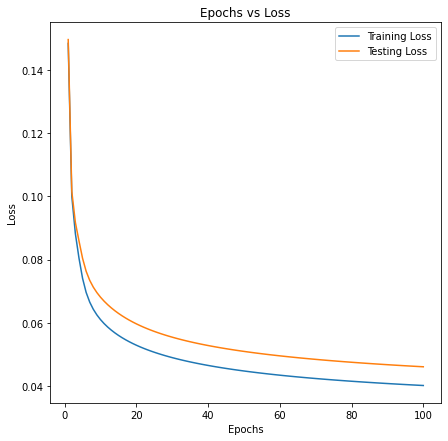

In [ ]:
# A.3.
ae.Plot()


In [ ]:
# A.4.

torch.manual_seed(42)

class TorchAE(nn.Module):

  def __init__(self,num_hidden_neurons,input_shape):
    super(TorchAE, self).__init__()
    self.hidden=nn.Linear(input_shape[1],num_hidden_neurons)
    self.output=nn.Linear(num_hidden_neurons,input_shape[1])

  def forward(self,X):
    X = torch.sigmoid(self.hidden(X))
    X = torch.sigmoid(self.output(X))
    return X

class AutoencoderTorch():

  def __init__(self,num_hidden_neurons,input_shape,lr,epochs,test):
    self.tae = TorchAE(num_hidden_neurons=2,input_shape=X.shape)
    self.opti = torch.optim.SGD(self.tae.parameters(), lr=lr)
    self.epochs = epochs
    self.X_test = test
    self.trainloss = []
    self.testloss = []

  def Fit(self,X):
    mse = nn.MSELoss()
    for epoch in range(self.epochs):
      for i in range(len(X)):
        self.opti.zero_grad()
        X_Cap = self.tae(X_train_tensor[i])
        MSE = mse(X_Cap,X_train_tensor[i])
        MSE.backward()
        self.opti.step()
      self.trainloss.append(mse(self.tae(X),X).item())
      self.testloss.append(mse(self.tae(self.X_test),self.X_test).item())

      print('Epoch : '+str(epoch+1)+', Train MSE : '+str(mse(self.tae(X),X).item())+', Test MSE : '+str(mse(self.tae(self.X_test),self.X_test).item()))  

  def Plot(self):
    plt.figure(figsize=(7,7))
    plt.plot(range(1,len(self.trainloss)+1),self.trainloss,label = 'Training Loss')
    plt.plot(range(1,len(self.testloss)+1),self.testloss,label = 'Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epochs vs Loss')
    plt.legend()
    plt.show()    
 

Epoch : 1, Train MSE : 0.1999351531267166, Test MSE : 0.2034255713224411
Epoch : 2, Train MSE : 0.1419362872838974, Test MSE : 0.14492005109786987
Epoch : 3, Train MSE : 0.10135382413864136, Test MSE : 0.10379389673471451
Epoch : 4, Train MSE : 0.09098982065916061, Test MSE : 0.09382133185863495
Epoch : 5, Train MSE : 0.08630091696977615, Test MSE : 0.08979597687721252
Epoch : 6, Train MSE : 0.0829123854637146, Test MSE : 0.08722566813230515
Epoch : 7, Train MSE : 0.0800015851855278, Test MSE : 0.08518079668283463
Epoch : 8, Train MSE : 0.0774642825126648, Test MSE : 0.08345293998718262
Epoch : 9, Train MSE : 0.0750965103507042, Test MSE : 0.08184587210416794
Epoch : 10, Train MSE : 0.07265949249267578, Test MSE : 0.08015848696231842
Epoch : 11, Train MSE : 0.070198655128479, Test MSE : 0.0783848837018013
Epoch : 12, Train MSE : 0.06799789518117905, Test MSE : 0.07673347741365433
Epoch : 13, Train MSE : 0.06615588814020157, Test MSE : 0.07526135444641113
Epoch : 14, Train MSE : 0.06459

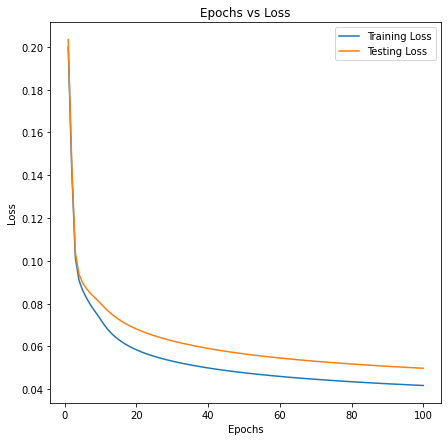

In [ ]:
X_train_tensor =torch.from_numpy(X_train).type(torch.FloatTensor)
X_test_tensor =torch.from_numpy(X_test).type(torch.FloatTensor)

at = AutoencoderTorch(num_hidden_neurons=2,input_shape=X.shape,lr = 0.3,epochs=100,test=X_test_tensor)
at.Fit(X_train_tensor)
at.Plot()

In [ ]:
Res = pd.DataFrame()
print('\t\t\t\t\t\t\tFinal Comparsion Table\n')
Res['Epochs '] = [(i+1) for i in range(len(ae.trainloss))]
Res['Training Loss \nUsing Numpy(TrN)'] = ae.trainloss
Res['Training Loss \nUsing Autograd(TrA)'] = at.trainloss
Res['Difference = \nabs(TrN-TrA))'] = np.abs(np.array(ae.trainloss)-np.array(at.trainloss))
Res['Testing Loss \nUsing Numpy(TeN)'] = ae.testloss
Res['Testing Loss \nUsing Autograd(TeA)'] = at.testloss
Res['Difference = \nabs(TeN-TeA))'] = np.abs(np.array(ae.testloss)-np.array(at.testloss))
print(tabulate(Res, headers = 'keys', tablefmt = 'psql'))

							Final Comparsion Table

+----+-----------+--------------------+-----------------------+-----------------+--------------------+-----------------------+-----------------+
|    |   Epochs  |     Training Loss  |        Training Loss  |   Difference =  |      Testing Loss  |         Testing Loss  |   Difference =  |
|    |           |   Using Numpy(TrN) |   Using Autograd(TrA) |   abs(TrN-TrA)) |   Using Numpy(TeN) |   Using Autograd(TeA) |   abs(TeN-TeA)) |
|----+-----------+--------------------+-----------------------+-----------------+--------------------+-----------------------+-----------------|
|  0 |         1 |          0.148417  |             0.199935  |      0.0515184  |          0.149624  |             0.203426  |      0.0538019  |
|  1 |         2 |          0.100033  |             0.141936  |      0.0419035  |          0.101562  |             0.14492   |      0.0433583  |
|  2 |         3 |          0.0881752 |             0.101354  |      0.0131786  |          0.091718